In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics, utils
import math
from collections import defaultdict

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [4]:
import matplotlib
matplotlib.rcParams['font.family']
matplotlib.rcParams['font.sans-serif'] = ['Arial']

In [5]:
df = pd.read_pickle('/nfs/turbo/coe-wiensjscr/opioid_optum/data/dataframes/naive_test.pkl')
df['patid'] = df['patid'].astype(int)
df

,patid,eligeff,eligend,yrdob,age_surg,gender,division,race,education,poverty,...,fill_recency_0,fill_recency_1,fill_recency_2,fill_recency_5,fill_recency_12,longest_fill_streak_0,longest_fill_streak_1,longest_fill_streak_2,longest_fill_streak_13,flg_prolonged_use
3845,802666510589307,2010-01-01,2016-09-30,1962.0,51.0,F,WEST NORTH CENTRAL,W,D,A,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
43620,802666521932503,2011-10-01,2015-07-31,1956.0,57.0,M,WEST SOUTH CENTRAL,W,U,A,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
197649,802666599941845,2012-07-01,2016-05-31,1975.0,38.0,M,WEST NORTH CENTRAL,W,C,U,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
91972,802666562760996,2010-09-01,2015-06-30,1981.0,32.0,M,SOUTH ATLANTIC,B,C,A,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
48964,802666526448681,2012-07-01,2016-09-30,1964.0,49.0,F,WEST NORTH CENTRAL,W,C,A,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74512,802666557093676,2014-01-01,2016-09-30,1953.0,62.0,F,EAST NORTH CENTRAL,B,C,A,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
133951,802666573262166,2010-01-01,2016-05-31,1980.0,35.0,F,MIDDLE ATLANTIC,A,C,A,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
82929,802666560349186,2008-01-01,2016-09-30,1976.0,39.0,M,WEST SOUTH CENTRAL,H,C,A,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
182743,802666596091768,2006-05-01,2016-09-30,1966.0,49.0,M,SOUTH ATLANTIC,W,B,A,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [6]:
list(df.columns)

['patid',
 'eligeff',
 'eligend',
 'yrdob',
 'age_surg',
 'gender',
 'division',
 'race',
 'education',
 'poverty',
 'home_owner',
 'house_income',
 'networth',
 'occupation',
 'num_adults',
 'num_child',
 'tobacco',
 'fst_serv_dt',
 'surg_dt',
 'lst_serv_dt',
 'inpatient',
 'conf_id',
 'dstatus',
 'los',
 'fst_surg',
 'proc_desc',
 'surg_gp',
 'days_post',
 'follow_ge24',
 'cci',
 'ane_prior_180',
 'ane_for_surg',
 'ane_181_365',
 'prior_365_31_opioid',
 'prior_30_opioid',
 'periop_opioid',
 'periop_opioid_adj',
 'p0_90_opioid',
 'p14_90_opioid',
 'p91_180_opioid',
 'p181_365_opioid',
 'ccs_650',
 'ccs_650_post',
 'ccs_651',
 'ccs_651_post',
 'ccs_652',
 'ccs_652_post',
 'ccs_656',
 'ccs_656_post',
 'ccs_657',
 'ccs_657_post',
 'ccs_658',
 'ccs_658_post',
 'ccs_659',
 'ccs_659_post',
 'ccs_660',
 'ccs_660_post',
 'ccs_661',
 'ccs_661_post',
 'ccs_662',
 'ccs_662_post',
 'ccs_663',
 'ccs_663_post',
 'ccs_670',
 'ccs_670_post',
 'ccs_84',
 'ccs_84_post',
 'ccs_202',
 'ccs_202_post',
 'c

In [8]:
df_out = df[['patid', 'surg_gp', 'tot_initial_postop_rx_ome', 'num_initial_postop_script', 'flg_refill', 'flg_prolonged_use']].copy()

In [9]:
df_out['index_Rx_OME_bin'] = pd.qcut(df_out['tot_initial_postop_rx_ome'], q=10, duplicates='drop')

In [10]:
df_out['flg_surg_major'] = (df_out['surg_gp'] == 'Major Surgery')

In [11]:
df_out['num_initial_postop_script'] = df_out['num_initial_postop_script'].astype(int)

In [14]:
df_out['flg_refill'].mean(), df_out['flg_prolonged_use'].mean(), df_out['flg_surg_major'].mean()

(0.10425155, 0.05119575, 0.17736935341009744)

In [15]:
import scipy

In [16]:
scipy.stats.pearsonr(df_out['tot_initial_postop_rx_ome'], df_out['flg_refill'])

(0.036547345077431743, 3.943350735689448e-08)

In [17]:
scipy.stats.pearsonr(df_out['tot_initial_postop_rx_ome'], df_out['flg_prolonged_use'])

(0.024512286837497732, 0.0002298516856614324)

In [18]:
scipy.stats.pearsonr(df_out['tot_initial_postop_rx_ome'], df_out['flg_surg_major'])

(0.12047943227773669, 9.046474724351239e-74)

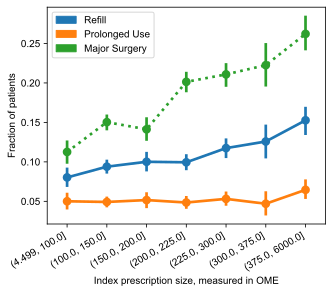

In [25]:
fig, ax = plt.subplots(figsize=(5,4))
sns.pointplot(x='index_Rx_OME_bin', y='flg_refill',        data=df_out, ax=ax, color='tab:blue')
sns.pointplot(x='index_Rx_OME_bin', y='flg_prolonged_use', data=df_out, ax=ax, color='tab:orange')
sns.pointplot(x='index_Rx_OME_bin', y='flg_surg_major',    data=df_out, ax=ax, color='tab:green', linestyles=':')

plt.legend(handles=[
    mpatches.Patch(color='tab:blue', label="Refill"),
    mpatches.Patch(color='tab:orange', label="Prolonged Use"),
    mpatches.Patch(color='tab:green', label="Major Surgery"),
])
plt.ylabel('Fraction of patients')
plt.xlabel('Index prescription size, measured in OME')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(30)

plt.savefig('index_fill_OME-REV1.svg', bbox_inches='tight')
plt.show()

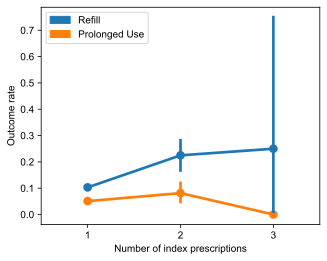

In [73]:
fig, ax = plt.subplots(figsize=(5,4))
sns.pointplot(x='num_initial_postop_script', y='flg_refill',        data=df_out, ax=ax, color='tab:blue')
sns.pointplot(x='num_initial_postop_script', y='flg_prolonged_use', data=df_out, ax=ax, color='tab:orange')
plt.legend(handles=[
    mpatches.Patch(color='tab:blue', label="Refill"),
    mpatches.Patch(color='tab:orange', label="Prolonged Use"),
])
plt.ylabel('Outcome rate')
plt.xlabel('Number of index prescriptions')
plt.savefig('fig/index_fill_NUM.svg', bbox_inches='tight')
plt.show()

In [80]:
path = '../preds/'
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def get_ys(model_name, outcome):
    y_true = np.load(path + outcome + '_test.npy')
    y_score = None
    if model_name == 'xgb' or model_name == 'linear_svc':
        y_score = np.load(path + model_name + '_' + outcome + '_y_score.npy')
    else:
        y_score = np.load(path + model_name + '_' + outcome + '_y_score.npz')['y_score']
    print(y_score)
    print(np.max(y_score))
    if model_name == 'linear_svc':
        for i in range(y_score.shape[0]):
            y_score[i] = sigmoid(y_score[i])
#     for i in range(y_score.shape[0]):
#         y_score[i] = (y_score[i] > 0.5)
    return y_true, y_score

In [98]:
y_trues, y_probs = get_ys('xgb', 'refill')
print(y_probs.mean())

df_out['refill_xgb_prob'] = y_probs
df_out['refill_xgb_prob_bin'] = pd.qcut(df_out['refill_xgb_prob'], q=5)

[0.45671746 0.08792327 0.18647243 ... 0.12339333 0.22428316 0.21287256]
0.65142155
0.20664856


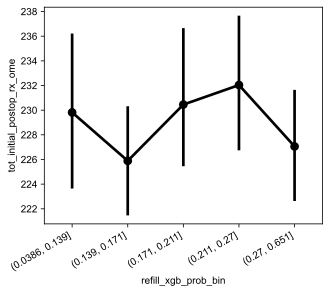

In [101]:
fig, ax = plt.subplots(figsize=(5,4))
sns.pointplot(x='refill_xgb_prob_bin', y='tot_initial_postop_rx_ome', data=df_out, ax=ax, color='k')
# plt.legend(handles=[
#     mpatches.Patch(color='tab:blue', label="Refill"),
#     mpatches.Patch(color='tab:orange', label="Prolonged Use"),
    
# ])
# plt.ylabel('Outcome rate')
# plt.xlabel('Index prescription size, measured in OME')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(30)

# plt.savefig('fig/index_fill_OME.svg', bbox_inches='tight')
plt.show()

In [102]:
y_trues, y_probs = get_ys('xgb', 'prolonged_use')
print(y_probs.mean())

df_out['pu_xgb_prob'] = y_probs
df_out['pu_xgb_prob_bin'] = pd.qcut(df_out['pu_xgb_prob'], q=5)

[0.19996582 0.09589901 0.07076149 ... 0.05077491 0.06330059 0.03943335]
0.4654883
0.060283933


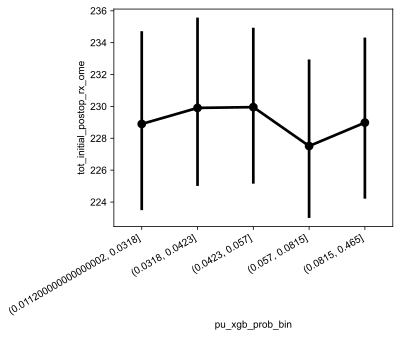

In [103]:
fig, ax = plt.subplots(figsize=(5,4))
sns.pointplot(x='pu_xgb_prob_bin', y='tot_initial_postop_rx_ome', data=df_out, ax=ax, color='k')
# plt.legend(handles=[
#     mpatches.Patch(color='tab:blue', label="Refill"),
#     mpatches.Patch(color='tab:orange', label="Prolonged Use"),
    
# ])
# plt.ylabel('Outcome rate')
# plt.xlabel('Index prescription size, measured in OME')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(30)

# plt.savefig('fig/index_fill_OME.svg', bbox_inches='tight')
plt.show()

In [3]:
def map_patid_to_feature(df, feature_string):
    mapping = {}
    df[feature_string] = df[feature_string].fillna(0)
    for index, row in df.iterrows():
        mapping[row.patid] = row[feature_string]
    return mapping

In [4]:
ome_feat = 'tot_initial_postop_rx_ome'
fill_num_feat = 'num_initial_postop_script'

In [6]:
ome_map = map_patid_to_feature(df, ome_feat)
fill_num_map = map_patid_to_feature(df, fill_num_feat)

In [ ]:
index_fills_ome = np.array(df.tot_initial_postop_rx_ome.fillna(0).tolist())
index_fills_num_scripts = np.array(df.num_initial_postop_script.fillna(0).tolist())

In [ ]:
df = df[df.flg_preop_rx != 1]
df = df.sort_values(by='patid')

In [ ]:
list(df)

In [ ]:
index_fills_ome = np.array(df.tot_initial_postop_rx_ome.fillna(0).tolist())
index_fills_num_scripts = np.array(df.num_initial_postop_script.fillna(0).tolist())

In [ ]:
model_name = 'xgb'
outcome = 'prolonged_use'
y_true = np.array(df['flg_' + outcome].fillna(0).tolist())

In [ ]:
def get_positive_rate(ys):
    return ys.sum() / len(ys)

def get_empirical_CI(ys):
    def bootstrap_func(i, ys):
        ys_b = utils.resample(ys, replace=True, random_state=i)
        return get_positive_rate(ys_b)
    
    values = []
    for i in range(1000):
        bootstrap_val = bootstrap_func(i, ys)
        if not math.isnan(bootstrap_val):
            values.append(bootstrap_val)
    return (np.percentile(values, 2.5), np.percentile(values, 97.5))

def get_analyses(index_data, y_true):
    median = np.median(index_data)
    y_trues_leq_than_median = np.logical_and(index_data <= median, y_true == 1)
    y_trues_g_than_median = np.logical_and(index_data > median, y_true == 1)
    
    rate_below_median = y_trues_leq_than_median.sum()/(index_data <= median).sum()
    rate_above_median = y_trues_g_than_median.sum()/(index_data > median).sum()
    
    leq_CI = get_empirical_CI(y_trues_leq_than_median)
    g_CI = get_empirical_CI(y_trues_g_than_median)
    
    print("Rate below median: {}%, 95% Empirical CI: ({}%, {}%)".format(rate_below_median*100, leq_CI[0]*100, leq_CI[1]*100))
    print("Rate above median: {}%, 95% Empirical CI: ({}%, {}%)".format(rate_above_median*100, g_CI[0]*100, g_CI[1]*100))

In [ ]:
def plot_bars(bins_to_vals, task, model_name, index_type, y_ticks, x_label, y_label, title):
    ### Get stuff to plot
    bin_ends = sorted(list(bins_to_vals.keys()))
    def get_interval_strings(bin_ends):
        def truncate(n, model_name):
            if model_name != 'true':
                return int(n*1000)/10
            else:
                return int(n)
        intervals = []
        left_end = 0
        for end in bin_ends:
            intervals.append("({}, {}]".format(truncate(left_end, model_name), truncate(end, model_name)))
            left_end = end
        return intervals
    x_labels = bin_ends
    if not (index_type == 'num_scripts' and model_name == 'true'):
        x_labels = get_interval_strings(bin_ends)
    bar_heights = []
    errors = np.zeros((2, len(x_labels)))
    index = 0
    for _, ys in bins_to_vals.items():
        bar_heights.append(get_positive_rate(ys))
        errors[:, index] = get_empirical_CI(ys, bar_heights[index])
        index += 1
    
    multiplier = 1
    if model_name == 'true':
        multiplier = 100
    bar_heights = np.array(bar_heights) * multiplier
    errors = errors * multiplier
        
    ### plot
    fig, ax = plt.subplots(figsize=(6, 10))
    ### get plot colors
    color_schemes = {
        'refill' : {
            'xgb'        : { 'OME' : 'forestgreen', 'num_scripts' : 'limegreen'}, 
            'linear_svc' : { 'OME' : 'blue', 'num_scripts' : 'skyblue'},
            'true'       : { 'OME' : 'chocolate', 'num_scripts' : 'sandybrown'}
        },
        'prolonged_use' : {
            'xgb'        : { 'OME': 'purple', 'num_scripts' : 'magenta'}, 
            'linear_svc' : { 'OME': 'orangered', 'num_scripts' : 'lightsalmon'},
            'true'       :  { 'OME' : 'gold', 'num_scripts' : 'lemonchiffon'}
        },
    }
    color = color_schemes[task][model_name][index_type]
    
    ### Set spacing of bar graph
    bar_size = 0.75
    padding = 0.25
    x_locs = np.arange(len(bar_heights)) * (bar_size + padding)
    
    rects = ax.bar(x = x_locs, width=bar_size, height=bar_heights, align='center', yerr=errors, color=color, error_kw=dict(lw=1, capsize=1, capthick=1))
    ax.set(xticks=x_locs, xticklabels=x_labels) 
    ax.set(yticks=y_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    fig.savefig(title + '.eps', format='eps', bbox_inches='tight')

In [ ]:
omes_to_y_trues = bin_by_quintile(index_fills_ome, y_trues)
omes_to_y_preds = bin_by_quintile(index_fills_ome, y_preds)

num_scripts_to_y_trues = bin_by_quintile(index_fills_num_scripts, y_trues)
num_scripts_to_y_preds = bin_by_quintile(index_fills_num_scripts, y_preds)

plot_bars(bins_to_vals=omes_to_y_trues, is_intervals=True, task='refill', model_name='true')

In [ ]:
def round_y(y):
    if y > 0.5:
        return 1
    else:
        return 0

In [ ]:
def bin_by_quintile(to_quintile, to_list):
    percentiles = [0.2, 0.4, 0.6, 0.8, 1.0]
    quintiles = np.quantile(a=to_quintile, q=percentiles)
    print(quintiles)
    
    def find_bucket(val, quintiles):
        for i in range(len(quintiles)):
            if val <= quintiles[i]:
                return quintiles[i]
        return -1
    
    bins_to_vals = defaultdict(list)
    for val, list_elt in zip(to_quintile, list_elt):
        bin_val = find_bucket(val, quintiles)
        assert bin_val > -1
        bins_to_vals[bin_val].append(list_elt)
    return bins_to_vals
    
    
def bin_by_val(to_make_bin, to_list):
    bins_to_vals = defaultdict(list)
    for val, list_elt in zip(to_make_bin, to_list):
        bins_to_vals[val].append(list_elt)
        
    return bins_to_vals

In [ ]:
path = '../preds/'
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def get_ys(model_name, outcome):
    y_true = np.load(path + outcome + '_test.npy')
    y_score = None
    if model_name == 'xgb' or model_name == 'linear_svc':
        y_score = np.load(path + model_name + '_' + outcome + '_y_score.npy')
    else:
        y_score = np.load(path + model_name + '_' + outcome + '_y_score.npz')['y_score']
    print(y_score)
    print(np.max(y_score))
    if model_name == 'linear_svc':
        for i in range(y_score.shape[0]):
            y_score[i] = sigmoid(y_score[i])
    for i in range(y_score.shape[0]):
        y_score[i] = (y_score[i] > 0.5)
    return y_true, y_score

In [ ]:
#outcome = 'prolonged_use'
outcome = 'refill'
#model_name = 'xgb'
model_name = 'linear_svc'

y_trues, y_preds = get_ys(model_name, outcome)

print(y_preds.sum())

omes_to_y_trues = bin_by_quintile(index_fills_ome, y_trues)
omes_to_y_preds = bin_by_quintile(index_fills_ome, y_preds)

num_scripts_to_y_trues = bin_by_val(index_fills_num_scripts, y_trues)
num_scripts_to_y_preds = bin_by_val(index_fills_num_scripts, y_preds)

# plot fills to outcomes
plot_bars(bins_to_vals=omes_to_y_trues, index_type="OME", task=outcome, model_name='true', y_ticks = np.arange(0, 13, 1), x_label="Index opioid prescription size (OME)", y_label='Rate of {} (%)'.format(outcome.replace("_", " ")), title='true_{}_OME'.format(outcome))
plot_bars(bins_to_vals=num_scripts_to_y_trues, index_type="num_scripts", task=outcome, model_name='true', y_ticks = np.arange(0, 17, 1), x_label="Number of index opioid prescriptions filled", y_label='Rate of {} (%)'.format(outcome.replace("_", " ")), title='true_{}_num_scripts'.format(outcome))

In [ ]:
outcome = 'prolonged_use'
#outcome = 'refill'
model_name = 'linear_svc'
y_trues, y_preds = get_ys(model_name, outcome)

# plot predictions to fills
y_preds_to_omes = bin_by_quintile(y_preds, index_fills_ome)
y_preds_to_num_scripts = bin_by_quintile(y_preds, index_fills_num_scripts)

plot_bars(bins_to_vals=y_preds_to_omes, index_type="OME", task=outcome, model_name=model_name, y_ticks = np.arange(0, 250, 50), x_label='Predicted risk of {} (%)'.format(outcome.replace("_", " ")), y_label="Index opioid prescription size (OME)", title='{}_{}_OME'.format(model_name, outcome))
plot_bars(bins_to_vals=y_preds_to_num_scripts, index_type="num_scripts", task=outcome, model_name=model_name, y_ticks = np.arange(0, 2, 1), x_label='Predicted risk of {} (%)'.format(outcome.replace("_", " ")), y_label="Number of index opioid prescriptions filled", title='{}_{}_num_scripts'.format(model_name, outcome))

model_name = 'xgb'
y_trues, y_preds = get_ys(model_name, outcome)
y_preds_to_omes = bin_by_quintile(y_preds, index_fills_ome)
y_preds_to_num_scripts = bin_by_quintile(y_preds, index_fills_num_scripts)
# plot predictions to fills
plot_bars(bins_to_vals=y_preds_to_omes, index_type="OME", task=outcome, model_name=model_name, y_ticks = np.arange(0, 250, 50), x_label='Predicted risk of {} (%)'.format(outcome.replace("_", " ")), y_label="Index opioid prescription size (OME)", title='{}_{}_OME'.format(model_name, outcome))
plot_bars(bins_to_vals=y_preds_to_num_scripts, index_type="num_scripts", task=outcome, model_name=model_name, y_ticks = np.arange(0, 2, 1), x_label='Predicted risk of {} (%)'.format(outcome.replace("_", " ")), y_label="Number of index opioid prescriptions filled", title='{}_{}_num_scripts'.format(model_name, outcome))